# Peteris ir Vilkas: Sustiprinamojo Mokymosi Įvadas

Šiame mokyme išmoksime, kaip pritaikyti sustiprinamąjį mokymą kelių paieškos problemai. Scenarijus įkvėptas [Peteris ir Vilkas](https://en.wikipedia.org/wiki/Peter_and_the_Wolf) muzikinės pasakos, sukurtos Rusijos kompozitoriaus [Sergejus Prokofjevas](https://en.wikipedia.org/wiki/Sergei_Prokofiev). Tai pasakojimas apie jauną pionierių Peterį, kuris drąsiai išeina iš savo namų į miško laukymę, kad persekiotų vilką. Mes treniruosime mašininio mokymosi algoritmus, kurie padės Peteriui tyrinėti aplinką ir sukurti optimalią navigacijos žemėlapį.

Pirmiausia, importuokime keletą naudingų bibliotekų:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Apžvalga apie pastiprinimo mokymą

**Pastiprinimo mokymas** (RL) yra mokymosi technika, leidžianti mums išmokti optimalaus **agentas** elgesio tam tikroje **aplinkoje**, atliekant daugybę eksperimentų. Agentas šioje aplinkoje turėtų turėti tam tikrą **tikslą**, apibrėžtą per **atlygio funkciją**.

## Aplinka

Dėl paprastumo, įsivaizduokime, kad Petro pasaulis yra kvadratinė lenta, kurios dydis yra `plotis` x `aukštis`. Kiekviena langelio dalis šioje lentoje gali būti:
* **žemė**, ant kurios Petras ir kiti padarai gali vaikščioti
* **vanduo**, ant kurio, akivaizdu, negalima vaikščioti
* **medis** arba **žolė** - vieta, kur galima šiek tiek pailsėti
* **obuolys**, kuris simbolizuoja tai, ką Petras norėtų rasti, kad galėtų pasimaitinti
* **vilkas**, kuris yra pavojingas ir kurio reikėtų vengti

Norėdami dirbti su aplinka, apibrėšime klasę, vadinamą `Board`. Kad ši užrašų knygelė nebūtų per daug apkrauta, visą kodą, susijusį su darbu su lenta, perkėlėme į atskirą modulį `rlboard`, kurį dabar importuosime. Galite peržiūrėti šį modulį, kad sužinotumėte daugiau apie vidinę įgyvendinimo struktūrą.


In [2]:
from rlboard import *

Dabar sukurkime atsitiktinę lentą ir pažiūrėkime, kaip ji atrodo:


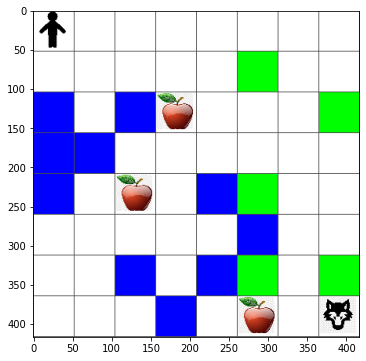

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Veiksmai ir politika

Mūsų pavyzdyje Petro tikslas būtų surasti obuolį, tuo pačiu vengiant vilko ir kitų kliūčių. Tam jis iš esmės gali vaikščioti aplinkui, kol suras obuolį. Taigi, bet kurioje pozicijoje jis gali pasirinkti vieną iš šių veiksmų: aukštyn, žemyn, kairėn ir dešinėn. Šiuos veiksmus apibrėšime kaip žodyną ir susiesime juos su atitinkamais koordinatės pokyčių poromis. Pavyzdžiui, judėjimas dešinėn (`R`) atitiktų porą `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

Mūsų agento (Peter) strategija apibrėžiama vadinamąja **politika**. Panagrinėkime paprasčiausią politiką, vadinamą **atsitiktiniu pasivaikščiojimu**.

## Atsitiktinis pasivaikščiojimas

Pirmiausia išspręskime mūsų problemą įgyvendindami atsitiktinio pasivaikščiojimo strategiją.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Paleiskime atsitiktinio pasivaikščiojimo eksperimentą kelis kartus ir pažiūrėkime vidutinį žingsnių skaičių:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Apdovanojimo funkcija

Norėdami padaryti mūsų politiką protingesnę, turime suprasti, kurie ėjimai yra „geresni“ už kitus.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Learning

Sukurkite Q-lentelę arba daugiamačio masyvo struktūrą. Kadangi mūsų lenta turi matmenis `width` x `height`, Q-lentelę galime atvaizduoti kaip numpy masyvą su forma `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Perduokite Q-lentelę į braižymo funkciją, kad lentelė būtų vizualizuota lentoje:


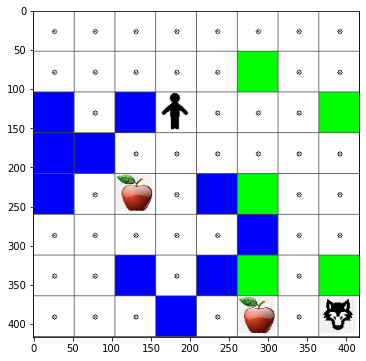

In [9]:
m.plot(Q)

## Q-Learning esmė: Bellmano lygtis ir mokymosi algoritmas

Parašykite pseudo-kodą mūsų mokymosi algoritmui:

* Inicializuokite Q-lentelę Q su vienodais skaičiais visoms būsenoms ir veiksmams
* Nustatykite mokymosi greitį $\alpha\leftarrow 1$
* Kartokite simuliaciją daug kartų
   1. Pradėkite atsitiktinėje pozicijoje
   1. Kartokite
        1. Pasirinkite veiksmą $a$ būsenoje $s$
        2. Įvykdykite veiksmą pereidami į naują būseną $s'$
        3. Jei pasiekiame žaidimo pabaigos sąlygą arba bendras atlygis yra per mažas - nutraukite simuliaciją  
        4. Apskaičiuokite atlygį $r$ naujoje būsenoje
        5. Atnaujinkite Q-funkciją pagal Bellmano lygtį: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. Atnaujinkite bendrą atlygį ir sumažinkite $\alpha$.

## Eksploatavimas vs. Tyrinėjimas

Geriausias požiūris yra subalansuoti tyrinėjimą ir eksploatavimą. Kai daugiau sužinome apie savo aplinką, labiau linkstame sekti optimalų maršrutą, tačiau kartais verta pasirinkti neištirtą kelią.

## Python įgyvendinimas

Dabar esame pasiruošę įgyvendinti mokymosi algoritmą. Prieš tai mums taip pat reikia funkcijos, kuri konvertuos atsitiktinius skaičius Q-lentelėje į tikimybių vektorių atitinkamiems veiksmams:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Pridedame nedidelį kiekį `eps` prie pradinio vektoriaus, kad išvengtume dalybos iš 0 pradiniu atveju, kai visi vektoriaus komponentai yra vienodi.

Tikrasis mokymosi algoritmas, kurį vykdysime 5000 eksperimentų, dar vadinamų **epochomis**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Įvykdžius šį algoritmą, Q-lentelė turėtų būti atnaujinta su reikšmėmis, kurios apibrėžia skirtingų veiksmų patrauklumą kiekviename žingsnyje. Vizualizuokite lentelę čia:


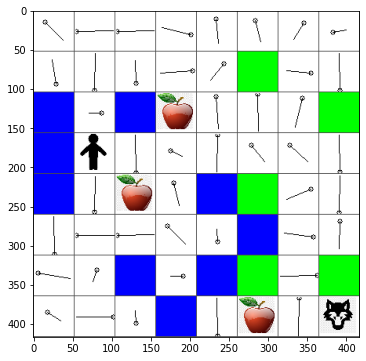

In [12]:
m.plot(Q)

## Tikrinti politiką

Kadangi Q-Lentelė nurodo kiekvieno veiksmo „patrauklumą“ kiekvienoje būsenoje, ją labai paprasta naudoti efektyviam navigavimui mūsų pasaulyje apibrėžti. Paprasčiausiu atveju galime tiesiog pasirinkti veiksmą, atitinkantį didžiausią Q-Lentelės reikšmę:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Jei kelis kartus išbandysite aukščiau pateiktą kodą, galite pastebėti, kad kartais jis tiesiog „užstringa“, ir jums reikia paspausti mygtuką STOP užrašų knygelėje, kad jį nutrauktumėte.

> **Užduotis 1:** Pakeiskite funkciją `walk`, kad apribotumėte maksimalų kelio ilgį tam tikru žingsnių skaičiumi (pvz., 100), ir stebėkite, kaip aukščiau pateiktas kodas retkarčiais grąžina šią reikšmę.

> **Užduotis 2:** Pakeiskite funkciją `walk`, kad ji negrįžtų į vietas, kuriose jau buvo anksčiau. Tai užkirs kelią funkcijai `walk` sudaryti kilpas, tačiau agentas vis tiek gali „įstrigti“ vietoje, iš kurios negali ištrūkti.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


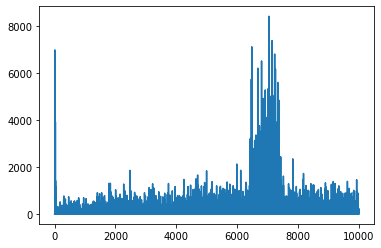

In [15]:
plt.plot(lpath)

Tai, ką matome čia, yra tai, kad iš pradžių vidutinis kelio ilgis padidėjo. Tai greičiausiai dėl to, kad kai nieko nežinome apie aplinką, esame linkę patekti į blogas būsenas, vandenį ar vilką. Kai sužinome daugiau ir pradedame naudoti šias žinias, galime ilgiau tyrinėti aplinką, tačiau vis dar gerai nežinome, kur yra obuoliai.

Kai pakankamai išmokstame, agentui tampa lengviau pasiekti tikslą, ir kelio ilgis pradeda mažėti. Tačiau mes vis dar atviri tyrinėjimui, todėl dažnai nukrypstame nuo geriausio kelio ir ieškome naujų galimybių, dėl ko kelias tampa ilgesnis nei optimalus.

Taip pat pastebime šiame grafike, kad tam tikru momentu kelio ilgis staiga padidėjo. Tai rodo proceso stochastinį pobūdį ir tai, kad tam tikru momentu galime „sugadinti“ Q-lentelės koeficientus, perrašydami juos naujomis reikšmėmis. Idealiu atveju tai turėtų būti sumažinta mažinant mokymosi tempą (t. y. mokymo pabaigoje Q-lentelės reikšmes koreguojame tik nedidele verte).

Apskritai svarbu prisiminti, kad mokymosi proceso sėkmė ir kokybė labai priklauso nuo parametrų, tokių kaip mokymosi tempas, mokymosi tempo mažėjimas ir nuolaidos koeficientas. Jie dažnai vadinami **hiperparametrais**, kad būtų atskirti nuo **parametrų**, kuriuos optimizuojame mokymo metu (pvz., Q-lentelės koeficientai). Geriausių hiperparametrų reikšmių paieškos procesas vadinamas **hiperparametrų optimizavimu**, ir jis nusipelno atskiros temos.


## Užduotis
#### Realistiškesnis pasaulis „Petras ir vilkas“

Mūsų situacijoje Petras galėjo judėti beveik be nuovargio ar alkio. Realistiškesniame pasaulyje jis turi kartais atsisėsti ir pailsėti, taip pat pasimaitinti. Padarykime mūsų pasaulį realistiškesnį, įgyvendindami šias taisykles:

1. Judėdamas iš vienos vietos į kitą, Petras praranda **energiją** ir įgyja **nuovargį**.
2. Petras gali padidinti energiją valgydamas obuolius.
3. Petras gali atsikratyti nuovargio ilsėdamasis po medžiu arba ant žolės (t. y. įžengdamas į lentos vietą, kur yra medis arba žolė - žalias laukas).
4. Petras turi surasti ir nužudyti vilką.
5. Kad nužudytų vilką, Petras turi turėti tam tikrą energijos ir nuovargio lygį, kitaip jis pralaimi kovą.

Pakeiskite aukščiau pateiktą atlygio funkciją pagal žaidimo taisykles, paleiskite stiprinamojo mokymosi algoritmą, kad išmoktumėte geriausią strategiją žaidimui laimėti, ir palyginkite atsitiktinio judėjimo rezultatus su savo algoritmu pagal laimėtų ir pralaimėtų žaidimų skaičių.

> **Pastaba**: Jums gali tekti koreguoti hiperparametrus, kad viskas veiktų, ypač epochų skaičių. Kadangi žaidimo sėkmė (kova su vilku) yra retas įvykis, galite tikėtis daug ilgesnio mokymosi laiko.



---

**Atsakomybės apribojimas**:  
Šis dokumentas buvo išverstas naudojant AI vertimo paslaugą [Co-op Translator](https://github.com/Azure/co-op-translator). Nors siekiame tikslumo, prašome atkreipti dėmesį, kad automatiniai vertimai gali turėti klaidų ar netikslumų. Originalus dokumentas jo gimtąja kalba turėtų būti laikomas autoritetingu šaltiniu. Kritinei informacijai rekomenduojama profesionali žmogaus vertimo paslauga. Mes neprisiimame atsakomybės už nesusipratimus ar klaidingus interpretavimus, atsiradusius naudojant šį vertimą.
